In [1]:
!pip install psycopg2-binary sshtunnel paramiko

Defaulting to user installation because normal site-packages is not writeable


## 1. Kết nối thành công 

In [2]:
from sshtunnel import SSHTunnelForwarder
import psycopg2

# Configuration for SSH and PostgreSQL
SSH_CONFIG = {
    "ssh_host": "103.253.20.13",      # SSH server address
    "ssh_port": 22,                  # SSH port
    "ssh_user": "ubuntu",            # SSH username
    "ssh_private_key": "C:/Users/User/.ssh/id_rsa"  # Path to SSH private key
}

DB_CONFIG = {
    "db_host": "localhost",           # Database host (localhost via SSH Tunnel)
    "db_port": 5434,                  # Database port
    "db_name": "postgres",            # Database name
    "db_user": "postgres",            # PostgreSQL username
    "db_password": "difyai123456"     # PostgreSQL password
}

def establish_ssh_tunnel(ssh_config, db_config):
    """
    Establish an SSH tunnel to the remote server.
    """
    try:
        tunnel = SSHTunnelForwarder(
            (ssh_config["ssh_host"], ssh_config["ssh_port"]),
            ssh_username=ssh_config["ssh_user"],
            ssh_private_key=ssh_config["ssh_private_key"],
            remote_bind_address=(db_config["db_host"], db_config["db_port"])
        )
        tunnel.start()
        print("SSH Tunnel established successfully!")
        return tunnel
    except Exception as e:
        print(f"Error establishing SSH Tunnel: {e}")
        raise

def connect_to_postgresql(tunnel, db_config):
    """
    Connect to PostgreSQL database through the SSH tunnel.
    """
    try:
        connection = psycopg2.connect(
            dbname=db_config["db_name"],
            user=db_config["db_user"],
            password=db_config["db_password"],
            host="127.0.0.1",  # Localhost because of SSH Tunnel
            port=tunnel.local_bind_port
        )
        print("Connected to PostgreSQL database successfully!")
        return connection
    except Exception as e:
        print(f"Error connecting to PostgreSQL: {e}")
        raise

def execute_query(connection, query):
    """
    Execute a query on the PostgreSQL database and return results.
    """
    try:
        cursor = connection.cursor()
        cursor.execute(query)
        results = cursor.fetchall()
        cursor.close()
        return results
    except Exception as e:
        print(f"Error executing query: {e}")
        raise

def query_postgresql_with_ssh(query):
    """
    Establish an SSH tunnel, connect to PostgreSQL, and execute a query.
    """
    try:
        # Establish SSH Tunnel
        tunnel = establish_ssh_tunnel(SSH_CONFIG, DB_CONFIG)

        # Connect to PostgreSQL
        connection = connect_to_postgresql(tunnel, DB_CONFIG)

        # Execute the query
        results = execute_query(connection, query)

        # Print the query results
        print(f"Query results for: {query}")
        for row in results:
            print(row)

        # Close the PostgreSQL connection
        connection.close()
        print("PostgreSQL connection closed.")

        # Stop the SSH tunnel
        tunnel.stop()
        print("SSH Tunnel stopped.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example Queries
if __name__ == "__main__":
    # Query to list all tables in the public schema
    query_postgresql_with_ssh("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';")
    

SSH Tunnel established successfully!
Connected to PostgreSQL database successfully!
Query results for: SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';
PostgreSQL connection closed.
SSH Tunnel stopped.


## 1.1 List all tables in the public schema


```
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'public' AND table_type = 'BASE TABLE'
ORDER BY table_name;

```

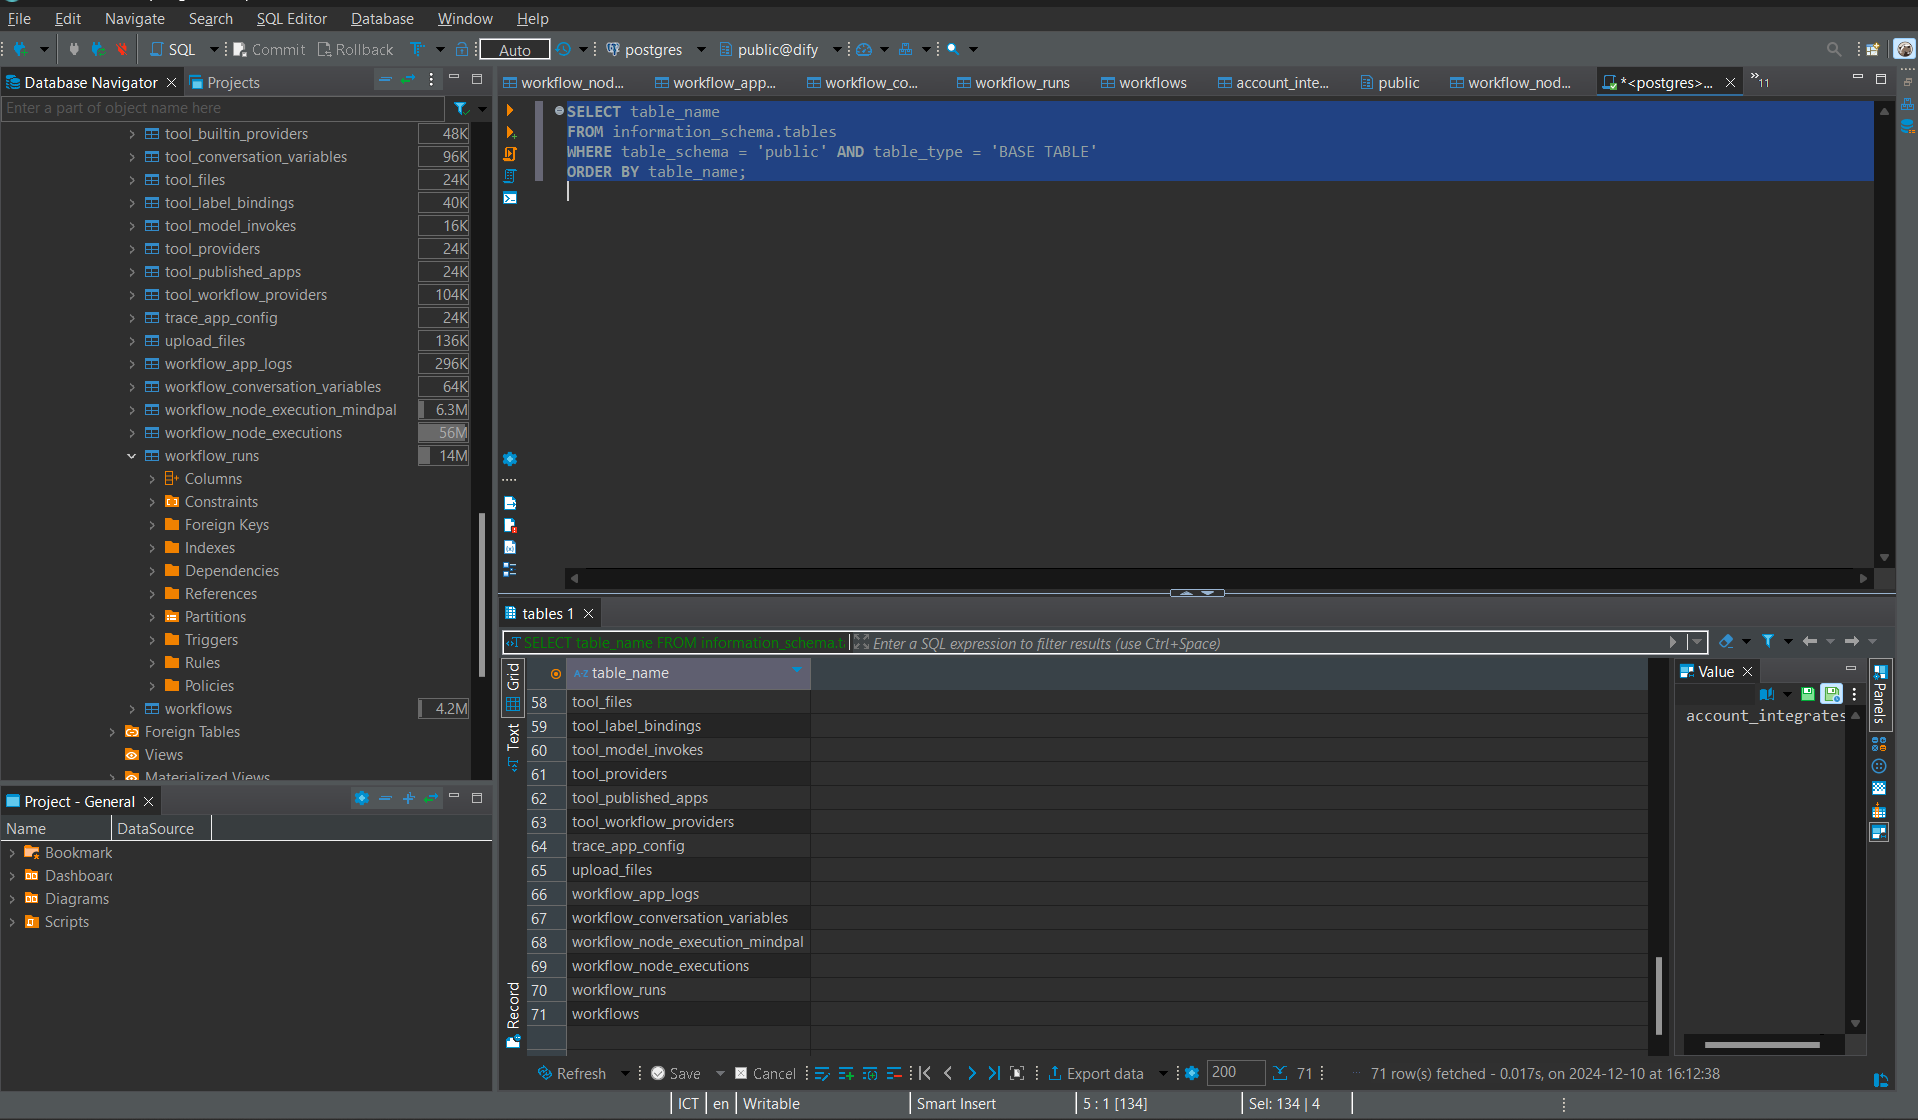

In [3]:
import psycopg2
from sshtunnel import SSHTunnelForwarder

# Cấu hình SSH và PostgreSQL
SSH_CONFIG = {
    "ssh_host": "103.253.20.13",      # Địa chỉ SSH server
    "ssh_port": 22,                  # Cổng SSH
    "ssh_user": "ubuntu",            # SSH username
    "ssh_private_key": "C:/Users/User/.ssh/id_rsa"  # Đường dẫn khóa SSH cá nhân
}

DB_CONFIG = {
    "db_host": "localhost",           # PostgreSQL host (thường là localhost qua SSH tunnel)
    "db_port": 5434,                  # Cổng PostgreSQL
    "db_name": "dify",                # Tên database
    "db_user": "postgres",            # Username PostgreSQL
    "db_password": "difyai123456"     # Mật khẩu PostgreSQL
}

def list_all_tables():
    """
    Liệt kê tất cả các bảng trong cơ sở dữ liệu PostgreSQL qua SSH Tunnel.
    """
    try:
        # Thiết lập SSH Tunnel
        with SSHTunnelForwarder(
            (SSH_CONFIG["ssh_host"], SSH_CONFIG["ssh_port"]),
            ssh_username=SSH_CONFIG["ssh_user"],
            ssh_private_key=SSH_CONFIG["ssh_private_key"],
            remote_bind_address=(DB_CONFIG["db_host"], DB_CONFIG["db_port"])
        ) as tunnel:
            print("SSH Tunnel đã kết nối!")

            # Kết nối PostgreSQL thông qua SSH Tunnel
            connection = psycopg2.connect(
                dbname=DB_CONFIG["db_name"],
                user=DB_CONFIG["db_user"],
                password=DB_CONFIG["db_password"],
                host="127.0.0.1",  # Localhost qua SSH Tunnel
                port=tunnel.local_bind_port
            )
            print("Kết nối PostgreSQL thành công!")

            # Tạo cursor và thực thi truy vấn
            cursor = connection.cursor()
            query = """
                SELECT table_schema, table_name
                FROM information_schema.tables
                WHERE table_type = 'BASE TABLE'
                ORDER BY table_schema, table_name;
            """
            cursor.execute(query)
            results = cursor.fetchall()

            # Hiển thị kết quả
            print("Danh sách các bảng:")
            for row in results:
                print(f"Schema: {row[0]}, Table: {row[1]}")

            # Đóng kết nối PostgreSQL
            cursor.close()
            connection.close()
            print("Đã đóng kết nối PostgreSQL.")

    except Exception as e:
        print("Có lỗi xảy ra:", e)

# Gọi hàm để liệt kê bảng
if __name__ == "__main__":
    list_all_tables()


SSH Tunnel đã kết nối!
Kết nối PostgreSQL thành công!
Danh sách các bảng:
Schema: information_schema, Table: sql_features
Schema: information_schema, Table: sql_implementation_info
Schema: information_schema, Table: sql_parts
Schema: information_schema, Table: sql_sizing
Schema: pg_catalog, Table: pg_aggregate
Schema: pg_catalog, Table: pg_am
Schema: pg_catalog, Table: pg_amop
Schema: pg_catalog, Table: pg_amproc
Schema: pg_catalog, Table: pg_attrdef
Schema: pg_catalog, Table: pg_attribute
Schema: pg_catalog, Table: pg_auth_members
Schema: pg_catalog, Table: pg_authid
Schema: pg_catalog, Table: pg_cast
Schema: pg_catalog, Table: pg_class
Schema: pg_catalog, Table: pg_collation
Schema: pg_catalog, Table: pg_constraint
Schema: pg_catalog, Table: pg_conversion
Schema: pg_catalog, Table: pg_database
Schema: pg_catalog, Table: pg_db_role_setting
Schema: pg_catalog, Table: pg_default_acl
Schema: pg_catalog, Table: pg_depend
Schema: pg_catalog, Table: pg_description
Schema: pg_catalog, Table:

## 1.2 Kiểm tra bảng `workflow_node_execution_mindpal`

Cách Kiểm Tra Xem Bảng Có Tồn Tại Không
Nếu bạn muốn xác minh chắc chắn bảng workflow_node_execution_mindpal tồn tại hay không, chạy truy vấn sau:

```sql
SELECT table_name 
FROM information_schema.tables 
WHERE table_schema = 'public' AND table_name = 'workflow_node_execution_mindpal';
```

Kiểm Tra Schema Khác

Có thể bảng workflow_node_execution_mindpal nằm trong một schema khác. Chạy lệnh sau để tìm bảng trong toàn bộ database:
```sql
SELECT table_schema, table_name 
FROM information_schema.tables 
WHERE table_name = 'workflow_node_execution_mindpal';
```

Nếu Bảng Tồn Tại Ở Schema Khác:

Sử dụng schema phù hợp trong query, ví dụ:
```sql
SELECT * FROM other_schema.workflow_node_execution_mindpal LIMIT 10;
```


In [4]:
def check_table_existence_and_query():
    """
    Kiểm tra sự tồn tại của bảng và query dữ liệu nếu bảng tồn tại.
    """
    try:
        # SSH Tunnel
        with SSHTunnelForwarder(
            (SSH_CONFIG["ssh_host"], SSH_CONFIG["ssh_port"]),
            ssh_username=SSH_CONFIG["ssh_user"],
            ssh_private_key=SSH_CONFIG["ssh_private_key"],
            remote_bind_address=(DB_CONFIG["db_host"], DB_CONFIG["db_port"])
        ) as tunnel:
            print("SSH Tunnel đã kết nối!")

            # PostgreSQL Connection
            connection = psycopg2.connect(
                dbname=DB_CONFIG["db_name"],
                user=DB_CONFIG["db_user"],
                password=DB_CONFIG["db_password"],
                host="127.0.0.1",
                port=tunnel.local_bind_port
            )
            print("Kết nối PostgreSQL thành công!")

            cursor = connection.cursor()

            # Kiểm tra sự tồn tại của bảng
            cursor.execute("""
                SELECT table_name
                FROM information_schema.tables
                WHERE table_schema = 'public' AND table_name = 'workflow_node_execution_mindpal';
            """)
            table_exists = cursor.fetchone()

            if table_exists:
                print("Bảng 'workflow_node_execution_mindpal' tồn tại!")
                # Query dữ liệu từ bảng
                cursor.execute("SELECT * FROM public.workflow_node_execution_mindpal LIMIT 10;")
                results = cursor.fetchall()
                print("Dữ liệu trong bảng:")
                for row in results:
                    print(row)
            else:
                print("Bảng 'workflow_node_execution_mindpal' không tồn tại.")

            # Đóng kết nối
            cursor.close()
            connection.close()
            print("Đã đóng kết nối PostgreSQL.")
    
    except Exception as e:
        print("Có lỗi xảy ra:", e)

# Chạy hàm kiểm tra và query
check_table_existence_and_query()


SSH Tunnel đã kết nối!
Kết nối PostgreSQL thành công!
Bảng 'workflow_node_execution_mindpal' tồn tại!
Dữ liệu trong bảng:
('f362830a-a56f-4289-8bd1-c671f99f9919', '51d7f795-a145-483b-bcdf-7ef374d7e9dd', 'add7a2c2-d508-458e-8fa4-908f47c650a5', '9732656e-e730-43de-8145-aa5abdbd47f8', 'single-step', 'ad817cd8-b45b-4210-80ed-3e7b820d28da', '263e0e8c-a47a-4c6b-8284-32a46dfe7fc9', 1, None, '1732032796505', 'tool', 'Select Knowledge', None, None, None, 'failed', 'Variable key 1732032796505.#1728356050308.who# not found in user inputs.', 0.017705785110592842, None, datetime.datetime(2024, 12, 3, 1, 59, 40, 690384), 'account', 'da8ab5b2-b5d0-460d-823b-856592af46ac', datetime.datetime(2024, 12, 3, 1, 59, 40, 690398), None)
('5d093e30-c538-4eb8-a9f3-dec976d669f8', '51d7f795-a145-483b-bcdf-7ef374d7e9dd', '456951fd-f19c-4161-bf77-8ba8715bbf7e', '715fecdf-8d7d-4333-915f-f3c49f3884c6', 'workflow-run', '000ab145-e799-4044-9b0d-66c2b5560140', '84a4b5b8-fa37-42b3-9f72-df08dc92e08f', 1, None, '1728382236

Xem các cột trong bảng `workflow_node_execution_mindpal`


In [5]:
def check_table_columns_and_query():
    """
    Kiểm tra sự tồn tại của bảng và in danh sách các cột trong bảng.
    """
    try:
        # SSH Tunnel
        with SSHTunnelForwarder(
            (SSH_CONFIG["ssh_host"], SSH_CONFIG["ssh_port"]),
            ssh_username=SSH_CONFIG["ssh_user"],
            ssh_private_key=SSH_CONFIG["ssh_private_key"],
            remote_bind_address=(DB_CONFIG["db_host"], DB_CONFIG["db_port"])
        ) as tunnel:
            print("SSH Tunnel đã kết nối!")

            # PostgreSQL Connection
            connection = psycopg2.connect(
                dbname=DB_CONFIG["db_name"],
                user=DB_CONFIG["db_user"],
                password=DB_CONFIG["db_password"],
                host="127.0.0.1",
                port=tunnel.local_bind_port
            )
            print("Kết nối PostgreSQL thành công!")

            cursor = connection.cursor()

            # Kiểm tra sự tồn tại của bảng
            cursor.execute("""
                SELECT table_name
                FROM information_schema.tables
                WHERE table_schema = 'public' AND table_name = 'workflow_node_execution_mindpal';
            """)
            table_exists = cursor.fetchone()

            if table_exists:
                print("Bảng 'workflow_node_execution_mindpal' tồn tại!")
                
                # Lấy danh sách các cột
                cursor.execute("""
                    SELECT column_name, data_type
                    FROM information_schema.columns
                    WHERE table_schema = 'public' AND table_name = 'workflow_node_execution_mindpal';
                """)
                columns = cursor.fetchall()
                print("Danh sách các cột trong bảng:")
                for column in columns:
                    print(f"Cột: {column[0]}, Loại dữ liệu: {column[1]}")

                # Query dữ liệu từ bảng
                cursor.execute("SELECT * FROM public.workflow_node_execution_mindpal LIMIT 10;")
                results = cursor.fetchall()
                print("Dữ liệu trong bảng:")
                for row in results:
                    print(row)
            else:
                print("Bảng 'workflow_node_execution_mindpal' không tồn tại.")

            # Đóng kết nối
            cursor.close()
            connection.close()
            print("Đã đóng kết nối PostgreSQL.")
    
    except Exception as e:
        print("Có lỗi xảy ra:", e)

# Chạy hàm kiểm tra và in cột
check_table_columns_and_query()


SSH Tunnel đã kết nối!
Kết nối PostgreSQL thành công!
Bảng 'workflow_node_execution_mindpal' tồn tại!
Danh sách các cột trong bảng:
Cột: id, Loại dữ liệu: uuid
Cột: tenant_id, Loại dữ liệu: uuid
Cột: app_id, Loại dữ liệu: uuid
Cột: workflow_id, Loại dữ liệu: uuid
Cột: triggered_from, Loại dữ liệu: character varying
Cột: workflow_run_id, Loại dữ liệu: uuid
Cột: workflow_node_execution_id, Loại dữ liệu: uuid
Cột: index, Loại dữ liệu: integer
Cột: predecessor_node_id, Loại dữ liệu: character varying
Cột: node_id, Loại dữ liệu: character varying
Cột: node_type, Loại dữ liệu: character varying
Cột: title, Loại dữ liệu: character varying
Cột: inputs, Loại dữ liệu: text
Cột: process_data, Loại dữ liệu: text
Cột: outputs, Loại dữ liệu: text
Cột: status, Loại dữ liệu: character varying
Cột: error, Loại dữ liệu: text
Cột: elapsed_time, Loại dữ liệu: double precision
Cột: execution_metadata, Loại dữ liệu: text
Cột: created_at, Loại dữ liệu: timestamp without time zone
Cột: created_by_role, Loại d

```
SSH Tunnel đã kết nối!
Kết nối PostgreSQL thành công!
Bảng 'workflow_node_execution_mindpal' tồn tại!
Danh sách các cột trong bảng:
Cột: id, Loại dữ liệu: uuid
Cột: tenant_id, Loại dữ liệu: uuid
Cột: app_id, Loại dữ liệu: uuid
Cột: workflow_id, Loại dữ liệu: uuid
Cột: triggered_from, Loại dữ liệu: character varying
Cột: workflow_run_id, Loại dữ liệu: uuid
Cột: workflow_node_execution_id, Loại dữ liệu: uuid
Cột: index, Loại dữ liệu: integer
Cột: predecessor_node_id, Loại dữ liệu: character varying
Cột: node_id, Loại dữ liệu: character varying
Cột: node_type, Loại dữ liệu: character varying
Cột: title, Loại dữ liệu: character varying
Cột: inputs, Loại dữ liệu: text
Cột: process_data, Loại dữ liệu: text
Cột: outputs, Loại dữ liệu: text
Cột: status, Loại dữ liệu: character varying
Cột: error, Loại dữ liệu: text
Cột: elapsed_time, Loại dữ liệu: double precision
Cột: execution_metadata, Loại dữ liệu: text
Cột: created_at, Loại dữ liệu: timestamp without time zone
Cột: created_by_role, Loại dữ liệu: character varying
Cột: created_by, Loại dữ liệu: uuid
Cột: finished_at, Loại dữ liệu: timestamp without time zone
Cột: node_execution_id, Loại dữ liệu: character varying
```

Danh sách các cột trong bảng 

order
```
- Work flow run id
- Tên workflow  (lấy bằng app_id)
- Link config của workflow (link mà mình nào nối start, LLM, end rồi ấn config để publish ấy)

- Điểm
- Bad response
- Input
- Context
- Prompt
- Output: lấy ở cột output
- Link conversation (lấy bằng app_id, workflow_run_id tức conversation_id)
```




```
SSH Tunnel đã kết nối!
Kết nối PostgreSQL thành công!
Bảng 'workflow_node_execution_mindpal' tồn tại!
Danh sách các cột trong bảng:
Cột: id, Loại dữ liệu: uuid
Cột: tenant_id, Loại dữ liệu: uuid
Cột: app_id, Loại dữ liệu: uuid
Cột: workflow_id, Loại dữ liệu: uuid
Cột: triggered_from, Loại dữ liệu: character varying
Cột: workflow_run_id, Loại dữ liệu: uuid
Cột: workflow_node_execution_id, Loại dữ liệu: uuid
Cột: index, Loại dữ liệu: integer
Cột: predecessor_node_id, Loại dữ liệu: character varying
Cột: node_id, Loại dữ liệu: character varying
Cột: node_type, Loại dữ liệu: character varying
Cột: title, Loại dữ liệu: character varying
Cột: inputs, Loại dữ liệu: text
Cột: process_data, Loại dữ liệu: text
Cột: outputs, Loại dữ liệu: text
Cột: status, Loại dữ liệu: character varying
Cột: error, Loại dữ liệu: text
Cột: elapsed_time, Loại dữ liệu: double precision
Cột: execution_metadata, Loại dữ liệu: text
Cột: created_at, Loại dữ liệu: timestamp without time zone
Cột: created_by_role, Loại dữ liệu: character varying
Cột: created_by, Loại dữ liệu: uuid
Cột: finished_at, Loại dữ liệu: timestamp without time zone
Cột: node_execution_id, Loại dữ liệu: character varying
```

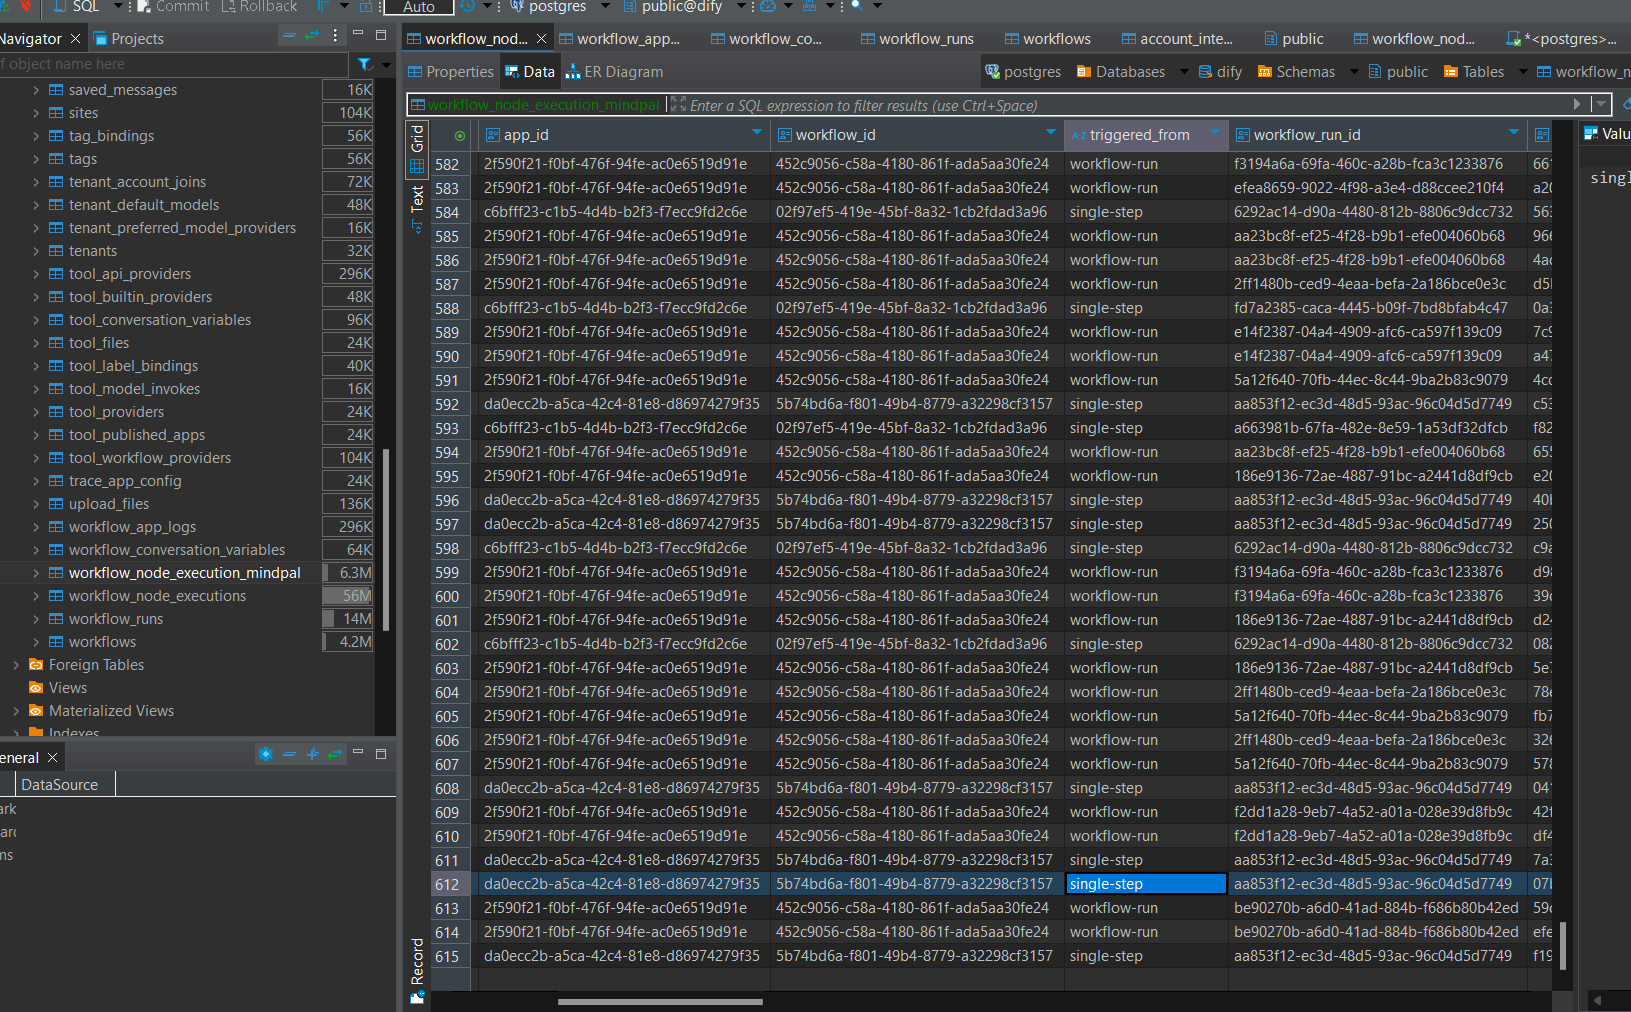

1. Dựa vào app_id, và workflow_run_id => Khởi tạo lại được conversation: http://103.253.20.13:9121/mindpal/da0ecc2b-a5ca-42c4-81e8-d86974279f35?conversation_id=aa853f12-ec3d-48d5-93ac-96c04d5d7749

In [6]:
def query_workflow_data():
    """
    Query các trường cần thiết từ bảng workflow_node_execution_mindpal.
    """
    try:
        # SSH Tunnel
        with SSHTunnelForwarder(
            (SSH_CONFIG["ssh_host"], SSH_CONFIG["ssh_port"]),
            ssh_username=SSH_CONFIG["ssh_user"],
            ssh_private_key=SSH_CONFIG["ssh_private_key"],
            remote_bind_address=(DB_CONFIG["db_host"], DB_CONFIG["db_port"])
        ) as tunnel:
            print("SSH Tunnel đã kết nối!")

            # PostgreSQL Connection
            connection = psycopg2.connect(
                dbname=DB_CONFIG["db_name"],
                user=DB_CONFIG["db_user"],
                password=DB_CONFIG["db_password"],
                host="127.0.0.1",
                port=tunnel.local_bind_port
            )
            print("Kết nối PostgreSQL thành công!")

            cursor = connection.cursor()

            # Query dữ liệu
            query = """
                SELECT 
                    workflow_run_id,
                    workflow_name,  -- Sửa lại tên cột thực tế nếu cần
                    config_link,    -- Sửa lại tên cột thực tế nếu cần
                    score,
                    bad_response,
                    input,
                    context,
                    prompt,
                    output,
                    conversation_link -- Sửa lại tên cột thực tế nếu cần
                FROM public.workflow_node_execution_mindpal
                LIMIT 10;
            """
            cursor.execute(query)
            results = cursor.fetchall()

            # Hiển thị kết quả
            print("Dữ liệu trong bảng theo yêu cầu:")
            for row in results:
                print(row)

            # Đóng kết nối PostgreSQL
            cursor.close()
            connection.close()
            print("Đã đóng kết nối PostgreSQL.")
    
    except Exception as e:
        print("Có lỗi xảy ra:", e)

# Chạy hàm query
query_workflow_data()


SSH Tunnel đã kết nối!
Kết nối PostgreSQL thành công!
Có lỗi xảy ra: column "workflow_name" does not exist
LINE 4:                     workflow_name,  -- Sửa lại tên cột thực ...
                            ^



dựa và

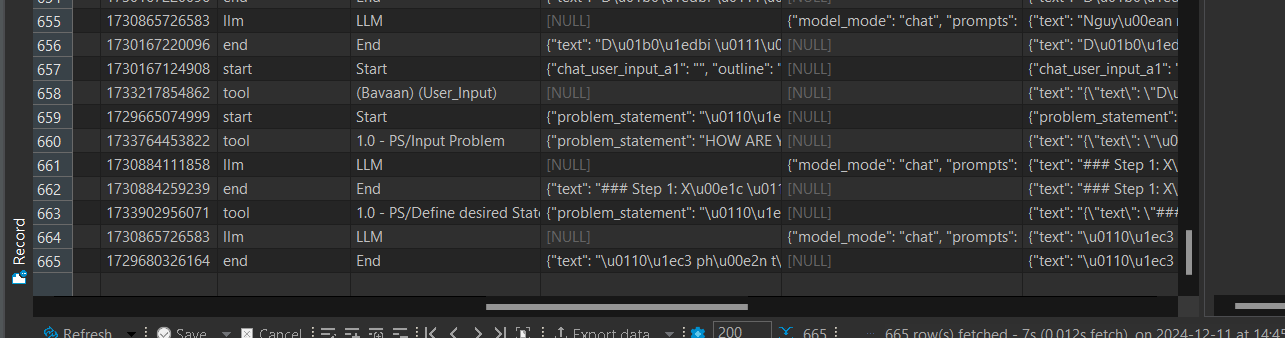

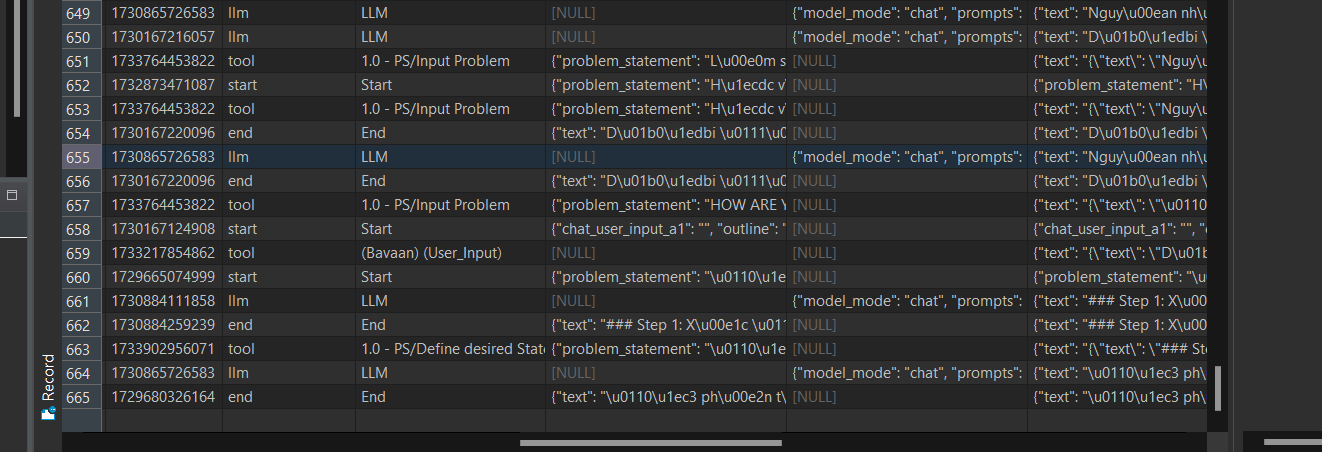

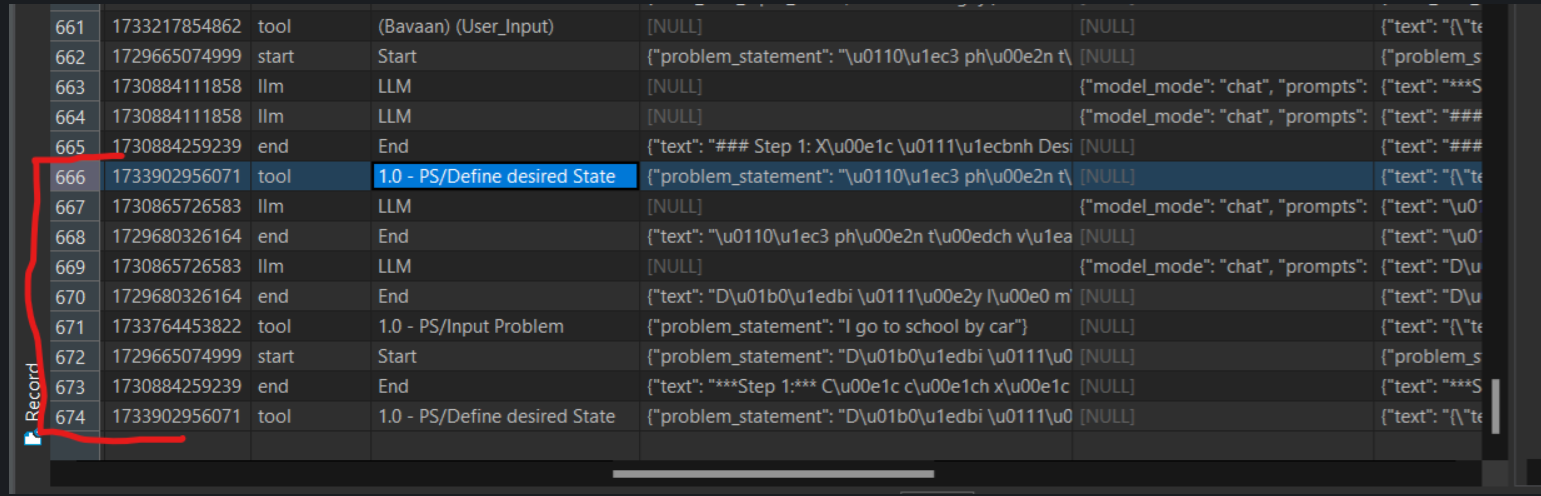

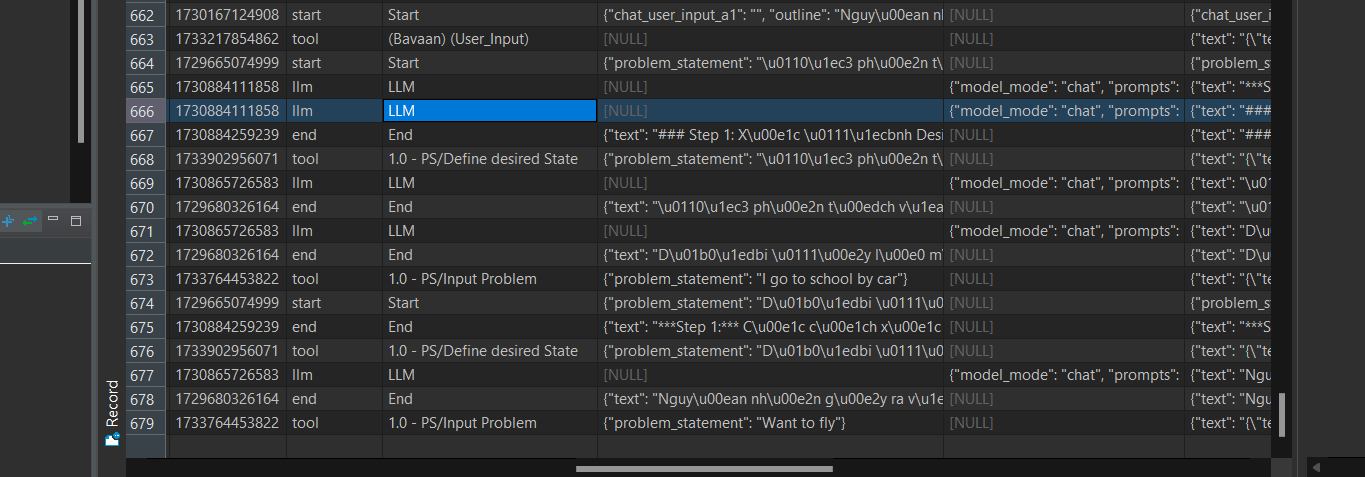

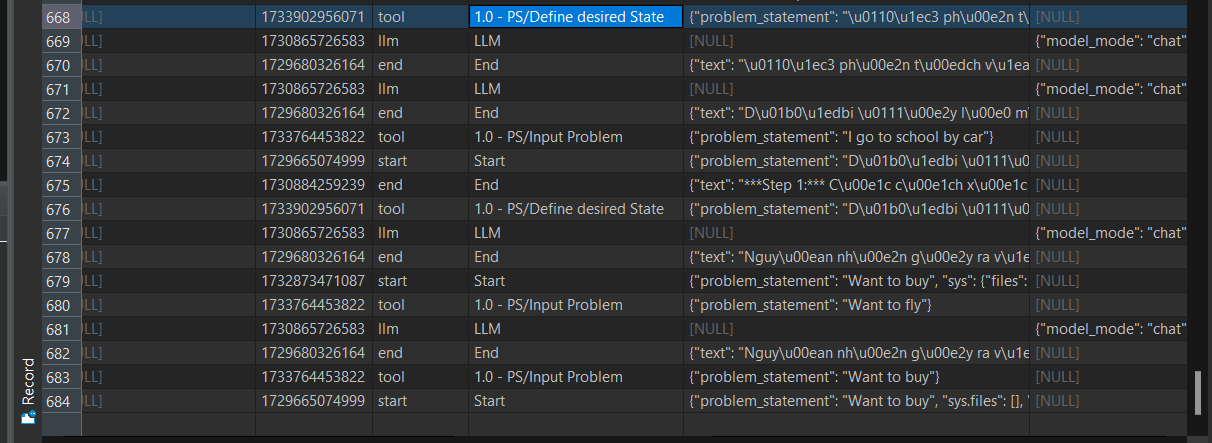

### Test với luồng mới hoàn toàn 

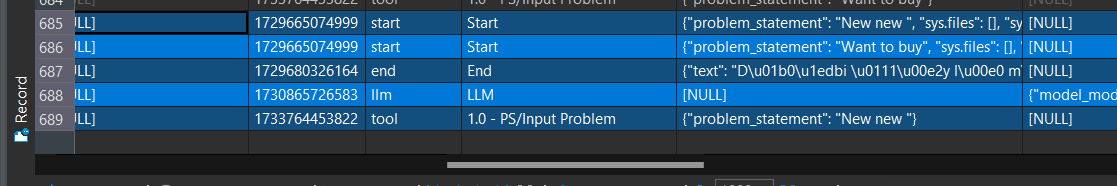

Khi mới run node "Input Problem" trong workflow

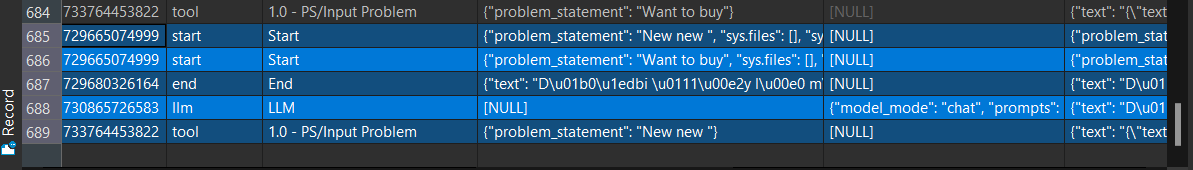

Đánh giá rating sẽ ở `meta_data` của node: 'tool'

Khi run thêm 1 node gen thứ 2 thì database nhảy như này

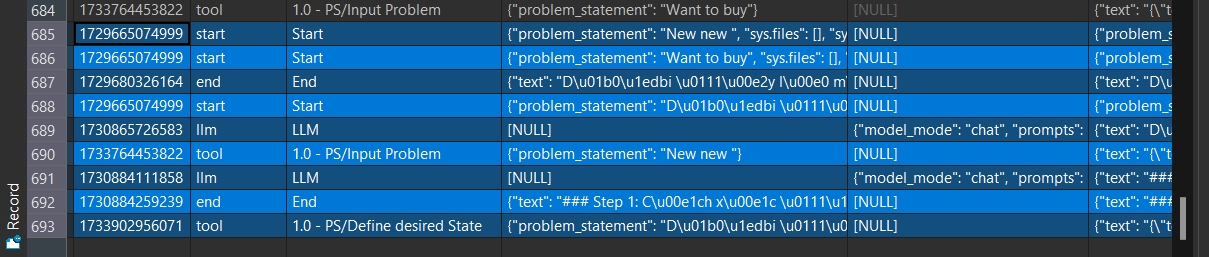

Thay đổi thành New New 2 

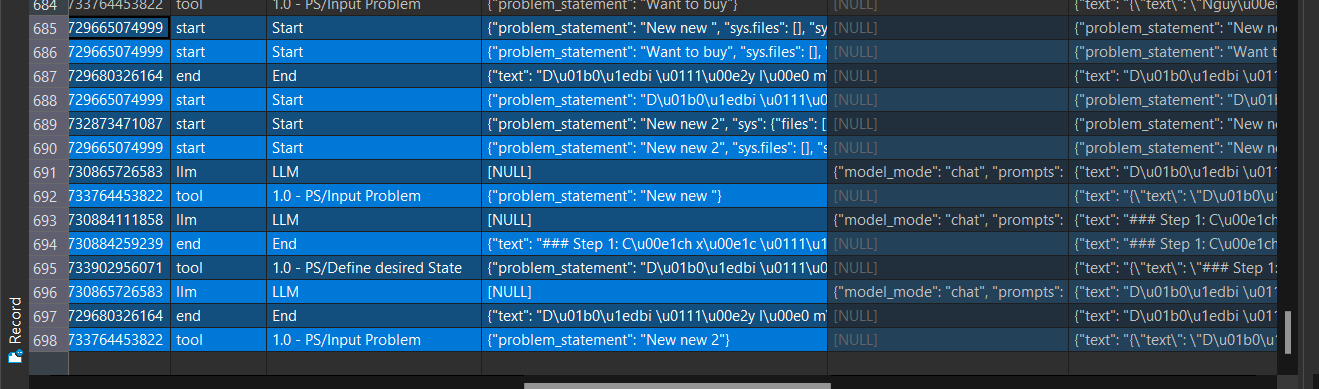

Khi rating cho new new 2 

```
{"tool_info": {"provider_type": "workflow", "provider_id": "3f7bf0a0-2cd3-4597-a57f-b11443194efb"}, "user_inputs": {"#1732873471087.problem_statement#": "New new "}, "rate": {"rating": 7, "updated_at": "2024-12-11 08:27:00", "account_id": "da8ab5b2-b5d0-460d-823b-856592af46ac"}}
```
```
{"tool_info": {"provider_type": "workflow", "provider_id": "3f7bf0a0-2cd3-4597-a57f-b11443194efb"}, "user_inputs": {"#1732873471087.problem_statement#": "New new 2"}, "rate": {"rating": 4, "updated_at": "2024-12-11 08:31:05", "account_id": "da8ab5b2-b5d0-460d-823b-856592af46ac"}}
```


```
{"tool_info": {"provider_type": "workflow", "provider_id": "9bb6c2ba-f44a-4693-9246-78f63efacd89"}, "user_inputs": {"#1733764453822.text#": "D\u01b0\u1edbi \u0111\u00e2y l\u00e0 m\u1ed9t s\u1ed1 nguy\u00ean nh\u00e2n g\u00e2y ra v\u1ea5n \u0111\u1ec1 newnew theo framework MECE:\n\n1. **Con ng\u01b0\u1eddi:**\n   - Thi\u1ebfu k\u1ef9 n\u0103ng ho\u1eb7c tr\u00ecnh \u0111\u1ed9 chuy\u00ean m\u00f4n c\u1ea7n thi\u1ebft.\n   - 2y nh\u00e9!"}, "rate": {"rating": 8, "updated_at": "2024-12-11 08:49:12", "account_id": "da8ab5b2-b5d0-460d-823b-856592af46ac"}}
```

```
9e14ecfc-5eed-441f-879a-feda13d0f168	51d7f795-a145-483b-bcdf-7ef374d7e9dd	da0ecc2b-a5ca-42c4-81e8-d86974279f35	5b74bd6a-f801-49b4-8779-a32298cf3157	single-step	4d889e24-d901-49d3-a187-9f8f62766120	2fbaa53f-c349-4ea6-bee0-16c79176f644	1		1733764453822	tool	1.0 - PS/Input Problem	{"problem_statement": "New new "}		{"text": "{\"text\": \"D\u01b0\u1\u00edt phu1edbc d\u01b0\u1edbi \u0111\u00e2y nh\u00e9!"}]}	succeeded		4.453751286491752	{"tool_info": {"provider_type": "workflow", "provider_id": "3f7bf0a0-2cd3-4597-a57f-b11443194efb"}, "user_inputs": {"#1732873471087.problem_statement#": "New new "}, "rate": {"rating": 7, "updated_at": "2024-12-11 08:27:00", "account_id": "da8ab5b2-b5d0-460d-823b-856592af46ac"}}	2024-12-11 08:08:51.238	account	da8ab5b2-b5d0-460d-823b-856592af46ac	2024-12-11 08:08:51.238	
```



```
9c2c2803-aea4-4f49-994c-af6301b21886	51d7f795-a145-483b-bcdf-7ef374d7e9dd	da0ecc2b-a5ca-42c4-81e8-d86974279f35	5b74bd6a-f801-49b4-8779-a32298cf3157	single-step	4d889e24-d901-49d3-a187-9f8f62766120	d3f6a114-7229-4122-b065-968d15942ff0	1		1733764453822	tool	1.0 - PS/Input Problem	{"problem_statement": "New new 2"}		{"text": "{\"text\": \"D\u01b0\u1edb \u0111\u00e2y nh\u00e9!\"}\n", "files": [], "json": [{"text": "D\u01b0\u1edbi \u0111\u00e2y l\u00ee2y nh\u00e9!"}]}	succeeded		3.6798210628330708	{"tool_info": {"provider_type": "workflow", "provider_id": "3f7bf0a0-2cd3-4597-a57f-b11443194efb"}, "user_inputs": {"#1732873471087.problem_statement#": "New new 2"}, "rate": {"rating": 4, "updated_at": "2024-12-11 08:31:05", "account_id": "da8ab5b2-b5d0-460d-823b-856592af46ac"}}	2024-12-11 08:29:28.322	account	da8ab5b2-b5d0-460d-823b-856592af46ac	2024-12-11 08:29:28.322	
```

### Sort theo create - at là bạn sẽ hiểu 

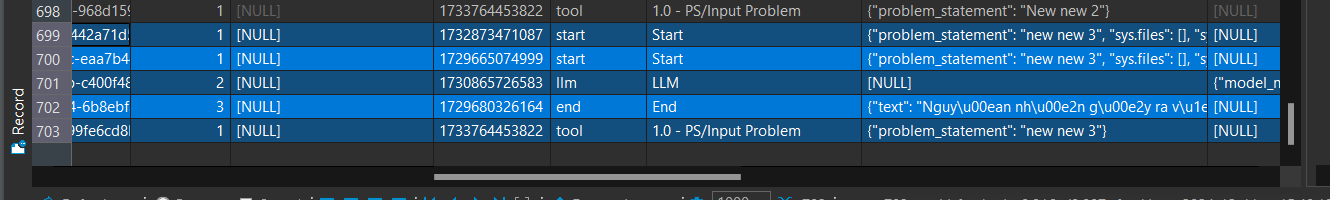

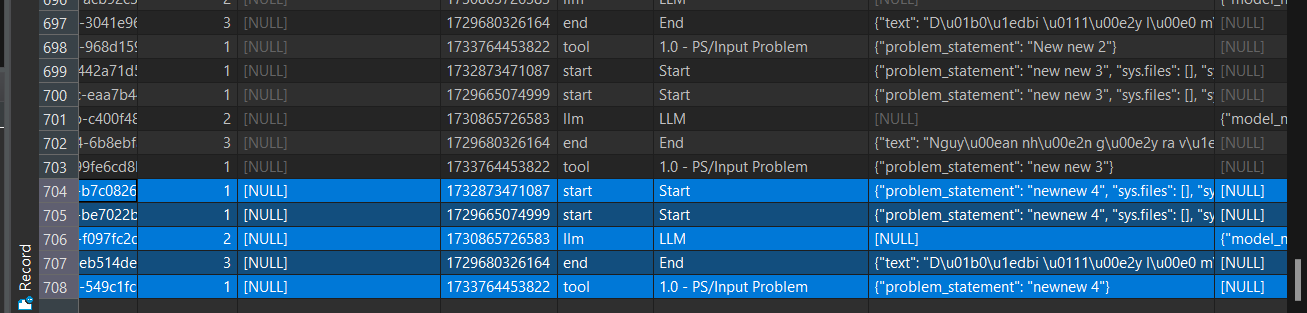

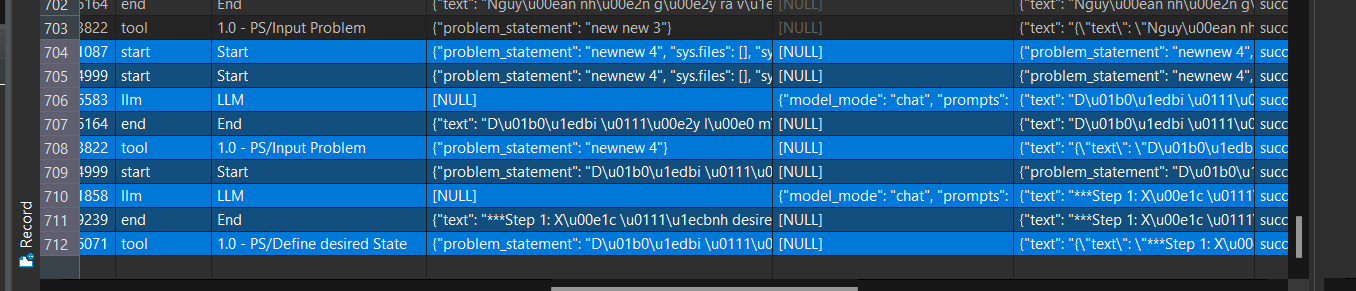

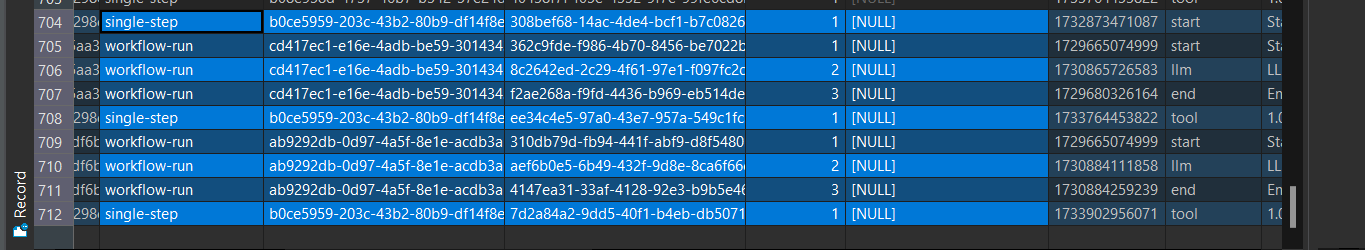


```
single-step (Start) - workflow-run(Start - LLM - End) - single-step(output của workflow-run 1)
- workflow-run(Start-LLM-End) - single-step(output của workflow-run 2)
```

Mục tiêu là tối ưu các feedback của các Node Tool bên trong workflow. 
1. Bảng `workflow_node_excution_mindpal`
2. Search lấy các node 'tool' trong cột `node_type`(tool)
- lấy `excution_metadata` của các node đó. 
thông tin bao gồm

```bash
{"tool_info": {"provider_type": "workflow", "provider_id": "9bb6c2ba-f44a-4693-9246-78f63efacd89"}, "user_inputs": {"#1733764453822.text#": "D\u01b0\u1edbi \u0111\u00e2y l\u00e0 m\u1ed9t s\u1ed1 nguy\u00ean nh\u00e2n g\u00e2y ra v\u1ea5n \u0111\u1ec1 newnew theo framework MECE:\n\n1. **Con ng\u01b0\u1eddi:**\n   - Thi\u1ebfu k\u1ef9 n\u0103ng ho\u1eb7c tr\u00ecnh \u0111\u1ed9 chuy\u00ean m\u00f4n c\u1ea7n thi\u1ebft.\n   - 2y nh\u00e9!"}, "rate": {"rating": 8, "updated_at": "2024-12-11 08:49:12", "account_id": "da8ab5b2-b5d0-460d-823b-856592af46ac"}}
```

Bạn lấy giúp tôi: 1. `provider_id`, 2. `user_inputs/text#`, 3. `rate`

3. lấy cột `inputs` và `outputs`, `title`, `node_type`
4. lấy cột `workflow_run_id`
- lấy toàn bộ những hàng có = `workflow_run_id` của nó. (Context)

## Ver 1 - Bảng raw

Mục tiêu là tối ưu các feedback của các Node Tool bên trong workflow. 
1. Truy cập bảng `workflow_node_excution_mindpal`
2. Trong cột `node_type`, truy cập `node_type` = `tool`
- Truy cập `excution_metadata` của các node đó. Nếu trong `excution_metadata` có "rate" thì lấy dòng data đó. 


```bash
{"tool_info": {"provider_type": "workflow", "provider_id": "9bb6c2ba-f44a-4693-9246-78f63efacd89"}, "user_inputs": {"#1733764453822.text#": "D\u01b0\u1edbi \u0111\u00e2y l\u00e0 m\u1ed9t s\u1ed1 nguy\u00ean nh\u00e2n g\u00e2y ra v\u1ea5n \u0111\u1ec1 newnew theo framework MECE:\n\n1. **Con ng\u01b0\u1eddi:**\n   - Thi\u1ebfu k\u1ef9 n\u0103ng ho\u1eb7c tr\u00ecnh \u0111\u1ed9 chuy\u00ean m\u00f4n c\u1ea7n thi\u1ebft.\n   - 2y nh\u00e9!"}, "rate": {"rating": 8, "updated_at": "2024-12-11 08:49:12", "account_id": "da8ab5b2-b5d0-460d-823b-856592af46ac"}}
```

---------------------------
AI viết: (nhờ input toàn bộ context trên)

```SQL
SELECT 
    id,
    workflow_run_id,
    app_id,
    title,
    node_type,
    inputs,
    outputs,
    execution_metadata::json -> 'tool_info' ->> 'provider_id' AS provider_id,
    execution_metadata::json -> 'user_inputs' ->> '#1733764453822.text#' AS user_inputs_text,
    execution_metadata::json -> 'rate' ->> 'rating' AS rating,
    execution_metadata::json -> 'rate' ->> 'updated_at' AS rate_updated_at,
    execution_metadata::json -> 'rate' ->> 'account_id' AS rate_account_id
FROM 
    public.workflow_node_execution_mindpal
WHERE 
    node_type = 'tool' 
    AND execution_metadata::jsonb ? 'rate';
```


1. **Chọn các cột cơ bản:**
   - `id`: ID của bản ghi.
   - `workflow_run_id`: ID của lần chạy workflow.
   - `title`: Tiêu đề của node.
   - `node_type`: Loại node (chỉ lấy `tool`).
   - `inputs` và `outputs`: Dữ liệu đầu vào và đầu ra của node.

2. **Trích xuất thông tin từ `execution_metadata`:**
   - `provider_id`: Lấy từ `execution_metadata -> tool_info -> provider_id`.
   - `user_inputs_text`: Lấy từ `execution_metadata -> user_inputs -> '#1733764453822.text#'`.
   - `rating`: Lấy từ `execution_metadata -> rate -> rating`.
   - `rate_updated_at`: Ngày cập nhật rating từ `execution_metadata -> rate -> updated_at`.
   - `rate_account_id`: ID người đánh giá từ `execution_metadata -> rate -> account_id`.

3. **Điều kiện lọc:**
   - `node_type = 'tool'`: Chỉ lấy các bản ghi có `node_type` là `tool`.
   - `execution_metadata::jsonb ? 'rate'`: Chỉ lấy các bản ghi mà `execution_metadata` chứa trường `rate`.


Ngon đã có đủ
```
Bạn lấy giúp tôi: 1. `provider_id`, 2. `user_inputs/text#`, 3. `rate`
Lấy cột `inputs` và `outputs`, `title`, `node_type``
```

Trong cột `workflow_run_id`
- lấy toàn bộ những hàng có `workflow_run_id`= `workflow_run_id` của nó. 

```SQL
WITH tool_nodes AS (
    SELECT 
        id,
        workflow_run_id,
        app_id,
        title,
        node_type,
        inputs,
        outputs,
        execution_metadata::json -> 'tool_info' ->> 'provider_id' AS provider_id,
        execution_metadata::json -> 'user_inputs' ->> '#1733764453822.text#' AS user_inputs_text,
        execution_metadata::json -> 'rate' ->> 'rating' AS rating,
        execution_metadata::json -> 'rate' ->> 'updated_at' AS rate_updated_at,
        execution_metadata::json -> 'rate' ->> 'account_id' AS rate_account_id
    FROM 
        public.workflow_node_execution_mindpal
    WHERE 
        node_type = 'tool' 
        AND execution_metadata::jsonb ? 'rate'
)
SELECT *
FROM public.workflow_node_execution_mindpal
WHERE workflow_run_id IN (SELECT workflow_run_id FROM tool_nodes);

```

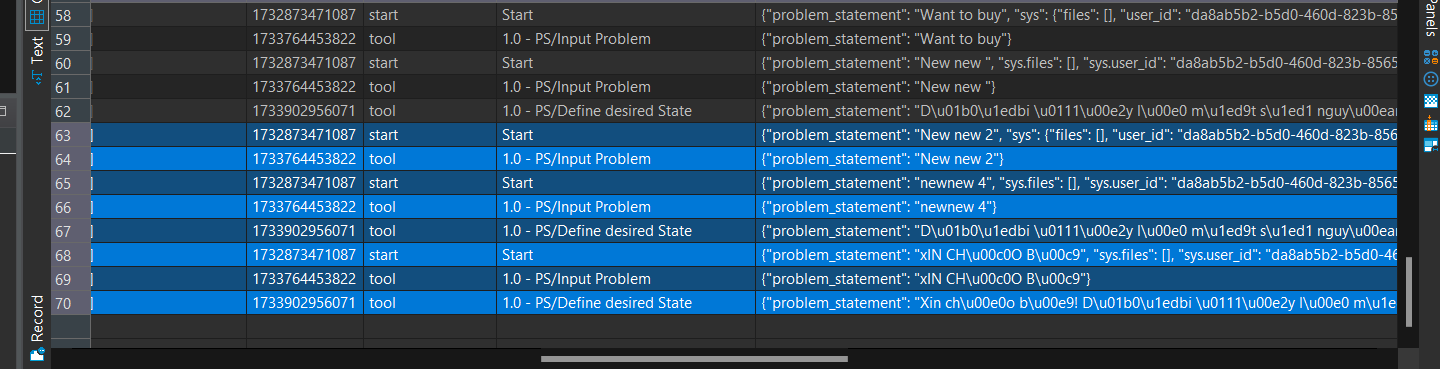



1. Sort create theo ngày . 
2. 
```SQL
WITH tool_nodes AS (
    SELECT 
        id,
        workflow_run_id,
        app_id,
        title,
        node_type,
        inputs,
        outputs,
        execution_metadata::json -> 'tool_info' ->> 'provider_id' AS provider_id,
        execution_metadata::json -> 'user_inputs' ->> '#1733764453822.text#' AS user_inputs_text,
        execution_metadata::json -> 'rate' ->> 'rating' AS rating,
        execution_metadata::json -> 'rate' ->> 'updated_at' AS rate_updated_at,
        execution_metadata::json -> 'rate' ->> 'account_id' AS rate_account_id
    FROM 
        public.workflow_node_execution_mindpal
    WHERE 
        node_type = 'tool' 
        AND execution_metadata::jsonb ? 'rate'
)
SELECT *
FROM public.workflow_node_execution_mindpal
WHERE workflow_run_id IN (SELECT workflow_run_id FROM tool_nodes);

```

3. Lấy thêm: 
(Vì đã sort theo hàng rồi). Nên là trong app_id, workflow_run_id quét hết toàn bộ những hàng kẹp giữa các hàng đó đó. 
- Search truy vấn lấy thêm các hàng có `node_type` = `llm`

```
1. Mình muốn cập nhật bảng: 
- Vẫn lấy các thông tin như cũ . 
- Ngoài ra lấy thêm các hàng có: các hàng có `node_type` = `llm`
Các hàng này kẹp giữa 2 hàng liền kề có cùng kẹp giữa 2 hàng các hàng có cùng app_id, workflow_run_id đã lấy -> hãy quét hết toàn bộ những hàng kẹp giữa các hàng đó đó.  (không quan tâm  app_id, workflow_id của các hàng lấy thêm này, chỉ quan tâm là nó kẹp giữa các hàng có cùng app_id, workflow_run_id đã lấy). Với điều kiên: các hàng có `node_type` = `llm`
```

Chẳng hạn như này 

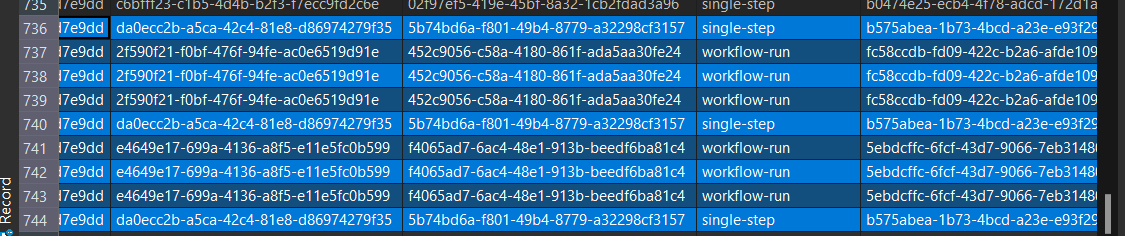

a Hùng ơi, mấy phần như này có chung "workflow_run_id".
Em muốn từ "tool" mà truy vấn ngược ra các LLM (để lấy prompt) (prompt của tool),
Em đang mắc đoạn này
2 files
 
image.png


image.png


4 replies
New


Đinh Hùng
  Yesterday at 7:34 PM
Chỗ này xem mối quan hệ các bảng xem có lấy ra được không?


Đinh Hùng
  Yesterday at 10:38 PM
Phần này chỗ này chỉ lấy được theo được kết quả của tool đánh giá và output của nó về Rating.
còn muốn truy vết xem nó từ workflow_id nào chạy khả năng phải lưu thêm.
=> Chỗ này đang có chút chạy Run MindPal đang lấy là theo bản workflow draft mà bản này cập nhật liên tục về sau không truy vết được kết nối.


Ngọc Cường Đoàn
  5 minutes ago
Em thấy trong các hàng dữ liệu ở giữa. Ở dòng LLM   là có prompt (prompt sau khi đã thêm tham số), ý là muốn lấy thì giờ cần code thêm hả anh.
Nếu code thêm thì tụi em order anh phần này được hông ạ. Estimate mất tầm bao lâu ạ.
image.png
 
image.png




Ngọc Cường Đoàn
  Just now
Hiện trong 1 conversation.
các node: start, tool1, tool2, end đang cùng 1 workflow_run_id. (Còn start-llm-end của từng tool 1, 2 thì lại cùng 1 workflow_run_id, nhưng mà khác).
Hay là ae mình cho nó chung hết luôn anh nhỉ.
(Check if tool được run trong workflow Mindpal to thì cho nó chung hết 1 workflow_run_id)
2 files
 
image.png


